# Código VAE with diffusion prior - Versão simplificada

* Obs: Deixei o código mais comentado para esse caso.

## Parte 1: DDPM prior

### a) Timestep embedding
* O objetivo é gerar uma representação contínua dos timesteps (por exemplo, 0, 1, …, T-1), convertendo eles em vetores contínuos por meio de funções trigonométricas (seno e cosseno)

* ***Equações do Positional encoding***:
Para uma posição $pos$ e uma dimensão $i$ do embedding:
$$ 
PE(pos,2i) = sin(\frac{pos}{1000^{2i/d_{model}}})
$$
    
$$ 
PE(pos,2i+1) = cos(\frac{pos}{1000^{2i/d_{model}}}),
$$

onde:
    * $pos$ seria o timestep (ou a posição) que queremos codificar;
    * $d_{model}$ é a dimensão total do embedding;
    * e para cada par de dimensões (uma para o seno e outra para o cosseno), o denominador $1000^{2i/d_{model}}$ garante que cada dimensão do embedding corresponde a uma frequência diferente.
    
* A codificação sinusoidal permite que o modelo saiba a posição (ou, no nosso caso, o timestep) usando funções senoidais e cosenoidais em diferentes frequências.

* Referências:
    * Denoising Diffusion Probabilistic Models (2020)
    * Attention is all you need (2023)

### c) DDPM loss
* Para cada amostra de z0 (latent extraído pelo encoder):
    1. Amostra um timestep t aleatório (de 0 a T-1).
    2. Calcula z_t = sqrt(prod_alpha[t]) * z0 + sqrt(1 - prod_alpha[t]) * epsilon,
         onde epsilon é ruído gaussiano.
    3. O modelo diffusion_prior tenta prever esse epsilon a partir de z_t e t.
    4. A loss é o erro quadrático médio (MSE) entre o ruído previsto e o ruído real.
    
* Equação do artigo:
$$ L_{DDPM} (x_0, \phi) = E_{t,x_0,x_t} [\frac{1}{2 \sigma_t ^2} ||\mu_\phi(x_t,t) - \tilde{\mu}_t(x_0,x_t)||^2],
$$
onde $\tilde{\mu}_t(x_0,x_t)$ é a média de $q(x_{t-1}|x_0,x_t)$, a forward diffusion posterior condicionada na observação $x_0$, $\mu_\phi(x_t,t)$ média prevista pelo modelo para o processo reverso e $\sigma_t ^2$ é a variância associada ao passo t.


* Efetuaremos uma reparametrização para usar o ruído no lugar de $\mu$, ou seja, se parametrizarmos o processo reverso de forma adequada, essa diferença entre as médias pode ser reescrita como a diferença entre o ruído real $\epsilon$ e uma predição do modelo: $||\mu_\phi(x_t,t) - \tilde{\mu}_t(x_0,x_t)||^2 \propto ||\epsilon_\phi(x_t,t) - \epsilon||^2$, onde $\epsilon_\phi(x_t,t)$ é a predição do ruído pelo modelo.
    * A reparametrização usada é $z_t = \sqrt{\Pi_{s=0} ^t \alpha_s}z_0 + \sqrt{1-\Pi_{s=0} ^t \alpha_s} \epsilon$, onde $z_0$ é a amostra do espaço latente (obtida do encoder), $\alpha_s = 1 - \beta_s$ (note que $\alpha_s$ representa a proporção da informação original que permanece após a adição de ruído naquele passo) e $\epsilon$ é amostrado de $N(0,I)$.
    * Tal formulação permite que a amostragem seja diferenciável.
    * Dessa forma, ao treinar o modelo para prever o ruído $\epsilon$ (por meio do MSE), garantimos que a aprendizagem está focada em como remover o ruído do estado atual $z_t$.
    
    
## Parte 2: VAE

### a) Encoder
* Responsável por levar os dados até o espaço latente.
* Usaremos duas redes convolucionais e calcularemos, usando camadas lineares, $\mu$ e $log \sigma^2$ da distribuição $q(z|x)$
* As duas saídas serão usadas para a reparametrização, onde amostramos $z$ a partir de $q(z|x)$.


### b) Decoder
* Responsável por levar do espaço latente até a reconstrução de imagens $(\hat{x})$.
* Primeiro, o vetor $z$ é transformado por uma camada linear e, em seguida, é desachatado.
* Usaremos duas redes convolucionais e usamos a função de ativação sigmoid de modo a garantir uma saída no intervalo [0,1], assim como estão as imagens normalizadas. 


### c) Reparametrização
* Usamos a equação $z = \mu(x) + \sigma(x) \odot \epsilon$, ou seja, $z_i = \mu_i + \sigma_i . \epsilon_i$

## Parte 3: Loss treinamento
* No artigo principal, a loss é dada por:
$$ \mathcal{L}(x;\phi, \theta, \psi) = E_{q_\psi}[log \frac{p_\theta(x|z)}{q_\psi (z|x)}] + E_{q_\psi} [L_{DDPM}(z_0;\phi)],
$$
onde $q_\psi(z|x)$ é a distribuição aproximada do encoder, $p_\theta (x|z)$ é o modelo de verossimilhança do decoder.

* De certo modo, a loss é escrita da forma: $Loss = reconstructed_{Loss} + Latent_{Loss}$.
    * A ***recon_loss*** é calculada como a Binary Cross-Entropy entre a imagem reconstruída e a imagem original.
    * A ***latent_loss***  é calculada a partir da loss de difusão. Essa parte substitui o termo tradicional da KL divergence.
    
* Lembrando que a função loss de difusão faz:
    1. A partir de $z_0$, é gerado o $z_t$ usando o forward do DDPM: $z_t = \sqrt{\Pi_{s=0} ^t \alpha_s}z_0 + \sqrt{1-\Pi_{s=0} ^t \alpha_s} \epsilon$, com $\epsilon \sim N(0,I)$.
    2. O diffusion prior $(\epsilon_\phi(z_t,t))$ tenta prever o ruído $\epsilon$.
    3. A loss é o erro quadrático médio (MSE) entre a predição do ruído e o ruído real: $DDPM_{loss} = ||\epsilon_\phi(z_t,t) - \epsilon||^2$
    
# Por que simplificada?
* Pouco uso da estrutura DCGAN
    * Redes mais simples sem Batch Normalization e poucas camadas
* Betas fixos e lineares
* Função de ativação padrão no prior DDPM

In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

#Parametros
hidden_dim=128
time_embed_dim=64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


############ DDPM ###################
#Variance schedule (fixed)
def beta_schedule(T,start=1e-4,end=2e-2):
    return torch.linspace(start, end, T)

#Positional encoding in timestep embedding
def timestep_embedding(timesteps, embedding_dim):
    """
    * Cria uma embedding sinusoidal para os timesteps, similar ao positional encoding.
        - Gera uma representação fixa e contínua dos timesteps
    * Funções:
        - Ao concatenar o timestep com a entrada (ex: vetor ruidoso z_t), o modelo recebe uma indicação 
        explícita de quanta informação foi degradada ou, inversamente, quanto “limpo” o vetor ainda é.
        - Usar vetores contínuos ajuda a rede a lidar com diferentes escalas de tempo sem a 
        necessidade de ter um parâmetro distinto para cada passo, tornando o modelo mais estável e eficiente.
    """
    half_dim = embedding_dim // 2 #separa a dimensão em duas partes: uma para cos e outra para seno
    # Calcula os coeficientes exponenciais para a embedding
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -(math.log(10000.0) / (half_dim - 1)))
        ## Gera ângulo (pos,i) = pos x 1000 ^{-i/{half_dim - 1}}
    emb = timesteps.float().unsqueeze(1) * emb.unsqueeze(0)  # [batch, half_dim]
        ## Calcula seno e cos (as primeiras half_dim posiçôes são para os senos e as outras para os cossenos)
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:  # se a dimensão for ímpar, completa com zeros (garante forma correta)
        emb = torch.cat([emb, torch.zeros(timesteps.size(0), 1, device=emb.device)], dim=1)
    return emb


class DiffusionPrior(nn.Module):
    def __init__(self, latent_dim, time_embed_dim=time_embed_dim, hidden_dim=hidden_dim):
        super(DiffusionPrior, self).__init__()
        #Nenhuma camada interna
        self.fc1 = nn.Linear(latent_dim + time_embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, z_t, t):
        # Obtém a embedding do timestep para cada amostra
        t_embed = timestep_embedding(t, self.fc1.in_features - z_t.size(1))
        # Concatena a representação ruidosa z_t com a embedding do tempo
        x = torch.cat([z_t, t_embed], dim=1)
        x = F.relu(self.fc1(x))
        noise_pred = self.fc2(x)
        return noise_pred

#loss ddpm
def ddpm_loss(diffusion_prior, z0, betas, alpha_bars, T):
    batch_size, latent_dim = z0.shape
    device = z0.device
    # Amostra um timestep t para cada exemplo no batch
    t = torch.randint(0, T, (batch_size,), device=device)
    # Recupera alpha_bar correspondente a cada t e ajusta o shape
    alpha_bar_t = alpha_bars[t].view(-1, 1)  # [batch, 1]
    # Amostra o ruído epsilon ~ N(0,I)
    epsilon = torch.randn_like(z0)
    # Calcula z_t conforme a fórmula do forward process do DDPM
        #alpha_bar_t = prod_alpha (0 até t)
    z_t = torch.sqrt(alpha_bar_t) * z0 + torch.sqrt(1 - alpha_bar_t) * epsilon
    # Prediz o ruído a partir de z_t e do timestep
    noise_pred = diffusion_prior(z_t, t)
    # Calcula o MSE entre o ruído real e o previsto
    loss = F.mse_loss(noise_pred, epsilon)
    return loss

# MNIST: imagens 1x28x28
############ VAE ###################
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        # Para MNIST: entrada 1x28x28
            # kernel_size = 4
            # stride = 2
            # padding = 1
            # dim_output = (28 - 4 + 2 x 1)/2 + 1 = 14 
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)  # -> 32x14x14
            # kernel_size = 4
            # stride = 2
            # padding = 1
            # dim_output = (14 - 4 + 2 x 1)/2 + 1 = 7
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) # -> 64x7x7
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim) #fc: fully connected (linear)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)
    
    def forward(self, x):
        batch_size = x.size(0)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(batch_size, -1)  # Flatten: ([batch_size,1,28,28] virou [batch_size, 1x28x28])
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 64 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  # -> 32x14x14
        self.deconv2 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)   # -> 1x28x28
    
    def forward(self, z):
        batch_size = z.size(0)
        x = self.fc(z)
        x = x.view(batch_size, 64, 7, 7)
        x = F.relu(self.deconv1(x))
        x = torch.sigmoid(self.deconv2(x))  # para imagens normalizadas entre 0 e 1
        return x

# Reparametrização
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

#Parametros
latent_dim = 32      # Dimensão do espaço latente
T = 100              # Número de passos de difusão
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cria a schedule de betas e calcula alphas e alpha_bars
betas = beta_schedule(T).to(device)         
alphas = 1 - betas                               
alpha_bars = torch.cumprod(alphas, dim=0)         

#Inicialização
encoder = Encoder(latent_dim).to(device)
decoder = Decoder(latent_dim).to(device)
diffusion_prior = DiffusionPrior(latent_dim).to(device)

#Otimizador em todos os parametros conjuntamente
optimizer = optim.Adam(list(encoder.parameters()) +
                       list(decoder.parameters()) +
                       list(diffusion_prior.parameters()), lr=1e-3)



In [3]:
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
# Sampling no Espaço Latente (Reverse Diffusion)

def sample_latent(diffusion_prior, T, latent_dim, betas, alpha_bars, device):
    # Inicializa z_T ~ N(0,I)
    z = torch.randn((1, latent_dim), device=device)
    # Loop reverso: de t = T-1 até 0
    for t in reversed(range(1, T)):
        t_tensor = torch.full((z.shape[0],), t, device=device, dtype=torch.long)
        # Predição do ruído usando o diffusion_prior
        pred_noise = diffusion_prior(z, t_tensor)
        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]
        # Equação para o passo reverso (simplificada):
        z = (z - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * pred_noise) / torch.sqrt(alpha_t)
        # Se t > 0, adiciona ruído
        if t > 0:
            noise = torch.randn_like(z)
            z = z + torch.sqrt(beta_t) * noise
    return z


# Inicialização dos Modelos  
    #Parametros
latent_dim = 32      # Dimensão do espaço latente
T = 100              # Número de passos de difusão
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Cria a schedule de betas e calcula alphas e alpha_bars
betas = beta_schedule(T).to(device)         
alphas = 1 - betas                               
alpha_bars = torch.cumprod(alphas, dim=0)   

encoder = Encoder(latent_dim).to(device)
decoder = Decoder(latent_dim).to(device)
diffusion_prior = DiffusionPrior(latent_dim, time_embed_dim=time_embed_dim, hidden_dim=hidden_dim).to(device)

optimizer = optim.Adam(list(encoder.parameters()) +
                       list(decoder.parameters()) +
                       list(diffusion_prior.parameters()), lr=1e-3)


# Dataset (MNIST)   

transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
real_folder = './real_images'
os.makedirs(real_folder, exist_ok=True)
count = 0
for imgs, _ in test_loader:
    for img in imgs:
        utils.save_image(img, os.path.join(real_folder, f"real_{count}.png"))
        count += 1
        if count >= 500:
            break
    if count >= 500:
        break 

# Loop de Treinamento       

num_epochs = 50
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    diffusion_prior.train()
    
    total_loss = 0.0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)
        optimizer.zero_grad()
        
        # Encoder
        mu, logvar = encoder(x)
        z0 = reparameterize(mu, logvar)
        
        # Decoder
        x_recon = decoder(z0)
        recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum') / x.size(0)
        
        # Loss do DDPM no espaço latente
        latent_loss = ddpm_loss(diffusion_prior, z0, betas, alpha_bars, T)
        
        loss = recon_loss + latent_loss
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.4f}")
    
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {total_loss/len(train_loader):.4f}")



C:\Users\leomi\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Epoch [1/50] Batch 0/469 - Loss: 523.2589
Epoch [1/50] Batch 100/469 - Loss: 134.7588
Epoch [1/50] Batch 200/469 - Loss: 93.7495
Epoch [1/50] Batch 300/469 - Loss: 74.7373
Epoch [1/50] Batch 400/469 - Loss: 73.7314
Epoch [1/50] Average Loss: 112.3108
Epoch [2/50] Batch 0/469 - Loss: 68.6722
Epoch [2/50] Batch 100/469 - Loss: 69.2231
Epoch [2/50] Batch 200/469 - Loss: 66.3275
Epoch [2/50] Batch 300/469 - Loss: 65.7662
Epoch [2/50] Batch 400/469 - Loss: 63.8274
Epoch [2/50] Average Loss: 65.7949
Epoch [3/50] Batch 0/469 - Loss: 65.3999
Epoch [3/50] Batch 100/469 - Loss: 61.8089
Epoch [3/50] Batch 200/469 - Loss: 61.3079
Epoch [3/50] Batch 300/469 - Loss: 63.7266
Epoch [3/50] Batch 400/469 - Loss: 64.8617
Epoch [3/50] Average Loss: 62.5186
Epoch [4/50] Batch 0/469 - Loss: 61.9283
Epoch [4/50] Batch 100/469 - Loss: 61.1236
Epoch [4/50] Batch 200/469 - Loss: 62.6423
Epoch [4/50] Batch 300/469 - Loss: 60.7558
Epoch [4/50] Batch 400/469 - Loss: 61.5425
Epoch [4/50] Average Loss: 61.0374
Epoch

Epoch [33/50] Batch 300/469 - Loss: 52.7923
Epoch [33/50] Batch 400/469 - Loss: 56.6232
Epoch [33/50] Average Loss: 55.9265
Epoch [34/50] Batch 0/469 - Loss: 57.1152
Epoch [34/50] Batch 100/469 - Loss: 56.3295
Epoch [34/50] Batch 200/469 - Loss: 55.1200
Epoch [34/50] Batch 300/469 - Loss: 57.1285
Epoch [34/50] Batch 400/469 - Loss: 56.1428
Epoch [34/50] Average Loss: 55.9049
Epoch [35/50] Batch 0/469 - Loss: 56.0739
Epoch [35/50] Batch 100/469 - Loss: 54.9107
Epoch [35/50] Batch 200/469 - Loss: 57.4723
Epoch [35/50] Batch 300/469 - Loss: 57.2111
Epoch [35/50] Batch 400/469 - Loss: 56.9168
Epoch [35/50] Average Loss: 55.8667
Epoch [36/50] Batch 0/469 - Loss: 55.7097
Epoch [36/50] Batch 100/469 - Loss: 54.4774
Epoch [36/50] Batch 200/469 - Loss: 56.4342
Epoch [36/50] Batch 300/469 - Loss: 56.7136
Epoch [36/50] Batch 400/469 - Loss: 53.6655
Epoch [36/50] Average Loss: 55.8308
Epoch [37/50] Batch 0/469 - Loss: 57.6015
Epoch [37/50] Batch 100/469 - Loss: 54.4855
Epoch [37/50] Batch 200/469 

In [3]:
#!pip install pytorch-fid

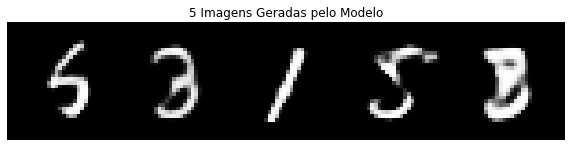

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\leomi\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:15<00:00, 13.54s/it]


FID: 50.95778229972345


In [4]:

############## Resultados ################
# 1) Gerar 5 Imagens Aleatórias Geradas 
num_img = 5
def generate_random_images(diffusion_prior, decoder, num_images, T, latent_dim, betas, alpha_bars, device):
    images = []
    for _ in range(num_images):
        # Amostra um vetor latente via reverse diffusion
        z = sample_latent(diffusion_prior, T, latent_dim, betas, alpha_bars, device)
        # Gera a imagem usando o decoder
        img = decoder(z)
        images.append(img)
    # Concatena em um grid para visualização
    images = torch.cat(images, dim=0)
    return images

# Gerar 5 imagens e exibi-las
diffusion_prior.eval()
decoder.eval()
with torch.no_grad():
    imgs = generate_random_images(diffusion_prior, decoder, num_img, T, latent_dim, betas, alpha_bars, device)
    
# Exibir as 5 imagens (cada uma [1,28,28])
imgs = imgs.cpu()
grid_img = utils.make_grid(imgs, nrow=5)
plt.figure(figsize=(10,5))
plt.imshow(grid_img.permute(1, 2, 0).squeeze(), cmap='gray')
plt.axis('off')
plt.title("5 Imagens Geradas pelo Modelo")
plt.show()


# 2) Calcular a Métrica FID

# Salvar um conjunto de imagens geradas pelo modelo:
fake_folder = './fake_images'
os.makedirs(fake_folder, exist_ok=True)
def save_images(images, folder, prefix):
    os.makedirs(folder, exist_ok=True)
    for i, img in enumerate(images):
        # Salva cada imagem individualmente
        utils.save_image(img, os.path.join(folder, f"{prefix}_{i}.png"))

# Gerar um conjunto maior de imagens geradas (exemplo: 500 imagens)
num_generated = 500
generated_images = []
with torch.no_grad():
    for _ in range(num_generated):
        z = sample_latent(diffusion_prior, T, latent_dim, betas, alpha_bars, device)
        img = decoder(z)
        generated_images.append(img)
generated_images = torch.cat(generated_images, dim=0)

# Salva as imagens geradas
save_images(generated_images, fake_folder, 'fake')

# Calculando FID
from pytorch_fid.fid_score import calculate_fid_given_paths

# Defina os caminhos dos diretórios
real_path = './real_images'
fake_path = fake_folder

# Calcular FID
fid_value = calculate_fid_given_paths([real_path, fake_path], batch_size=50, device=device, dims=2048)
print(f"FID: {fid_value}")